# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import adaptive_latents.transforms.utils as fin
import tqdm as tqdm
from adaptive_latents import NumpyTimedDataSource
import adaptive_latents.plotting_functions as bpf
import adaptive_latents.input_sources.datasets as datasets
import sklearn.decomposition
import pandas as pd
import adaptive_latents
from adaptive_latents.transforms.jpca import apply_prosvd_and_sjpca_and_cache

In [2]:
def smooth_columns(X, t, kernel_length=5, kernel_end=-3):
    kernel = np.exp(np.linspace(0, kernel_end, kernel_length))
    kernel /= kernel.sum()
    mode = 'valid'
    X = np.column_stack([np.convolve(kernel, column, mode) for column in X.T])
    t = np.convolve(np.hstack([[1],kernel[:-1]*0]), t, mode)
    return X, t 

In [3]:
dataset_chosen = "jenkins"

In [4]:
if dataset_chosen == "buzaki":
    obs, raw_behavior, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_buzaki_data(individual_identifier=adaptive_latents.input_sources.datasets.individual_identifiers["buzaki"][0], bin_width=0.03)
    ###
    resampled_behavior = fin.resample_matched_timeseries(raw_behavior, bin_centers, beh_t)
    hd = np.arctan2(resampled_behavior[:,0] - resampled_behavior[:,2], resampled_behavior[:,1] - resampled_behavior[:,3])
    beh = resampled_behavior[:,:2]
    ###
    pre_datasets = {
        's([obs,pos],6) # i': fin.prosvd_data(input_arr=np.hstack([obs, beh]), output_d=6, init_size=50),
        's(z([obs,pos]),4) # i': fin.prosvd_data(input_arr=fin.zscore(np.hstack([obs, beh])), output_d=4, init_size=50),
        's(obs,6) # i o': fin.prosvd_data(input_arr=obs, output_d=6, init_size=50),
        'pos # i o' : beh,
        
    
        'hd # o': hd.reshape(-1,1),
        # 'pca(obs,2) # i o' : sklearn.decomposition.PCA(n_components=2).fit_transform(obs),
    }
    
    for key, value in pre_datasets.items():
        pre_datasets[key] = fin.clip(value, beh_t)


## Indy

In [5]:
if dataset_chosen == "indy":

    
    obs, beh, bin_centers, beh_t = adaptive_latents.input_sources.datasets.construct_indy_data(
        adaptive_latents.input_sources.datasets.individual_identifiers["indy"][0],
        bin_width=0.03,
    )
    
    resampled_behavior = fin.resample_matched_timeseries(beh, bin_centers, beh_t)
    beh, beh_t = resampled_behavior, bin_centers


    pre_smooth_obs, pre_smooth_bin_centers = obs, bin_centers
    obs, bin_centers = smooth_columns(obs, bin_centers, kernel_end=-3)

    
    
    pre_datasets = {
        'beh # o': (beh, beh_t),
        'j(s(obs,4))[:,0] # i o': fin.clip(apply_prosvd_and_sjpca_and_cache(input_arr=obs, intermediate_d=4, output_d=4)[:,0], bin_centers),
        's(obs,4) # i o': fin.clip(fin.prosvd_data(input_arr=obs, output_d=4, init_size=30, centering=True), bin_centers),
        'j(s(obs,4)) # i o': fin.clip(apply_prosvd_and_sjpca_and_cache(input_arr=obs, intermediate_d=4, output_d=4), bin_centers),

    
    }

## Jenkins

In [14]:
if dataset_chosen == "jenkins":
    obs, beh, obs_t, beh_t = adaptive_latents.input_sources.datasets.construct_jenkins_data(bin_width=0.06)
    beh, beh_t = fin.resample_matched_timeseries(beh, obs_t, beh_t), obs_t
    obs, obs_t = smooth_columns(obs, obs_t, kernel_length=20)
    pre_datasets = {
        's(obs,4) # i o': (fin.prosvd_data(input_arr=obs, output_d=4, init_size=4, centering=True), obs_t),
        'j(s(obs,4)) # i o': (apply_prosvd_and_sjpca_and_cache(input_arr=obs, intermediate_d=4, output_d=4), obs_t),
        'j(s(obs,4))[:,0] # o': (apply_prosvd_and_sjpca_and_cache(input_arr=obs, intermediate_d=4, output_d=4)[:,0:1], obs_t),
        's(obs,4)[:,0] # o': (fin.prosvd_data(input_arr=obs, output_d=4, init_size=4, centering=True)[:,0:1], obs_t),
        'beh # o': (beh, beh_t),
    }
    
    for key, value in pre_datasets.items():
        x, x_t = fin.clip(*value)
        idx = ~np.any(np.isnan(x), axis=1)
        x, x_t = x[idx], x_t[idx]
        pre_datasets[key] = (x, x_t)
        



retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_665900114337442.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/apply_prosvd_and_sjpca_and_cache_538776046463548.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/apply_prosvd_and_sjpca_and_cache_538776046463548.pickle
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/prosvd_data_665900114337442.pickle


In [15]:
with_randoms = {}
for key, value in pre_datasets.items():
    k = key.replace("🌀", "")
    with_randoms[k] = value
    if "🌀" in key:
        k, tags = k.split("#")
        k = k.strip()
        with_randoms[f"shuf({k}) #{tags.strip()}"] = (*fin.shuffle_time(value[0]), value[1])

datasets = {}
input_keys = []
output_keys = []
for key, value in with_randoms.items():
    k, tags = key.split("#")
    k = k.strip()
    datasets[k] = value
    assert np.all(np.isfinite(value[0]))
    if "i" in tags:
        input_keys.append(k)
    if "o" in tags:
        output_keys.append(k)
        if "b" in tags:
            a, t = value
            for i in range(a.shape[1]):
                new_k = k + f"[:,{i}]"
                datasets[new_k] = (a[:,i:i+1],t)
                output_keys.append(new_k)

In [16]:
t1 = 1200

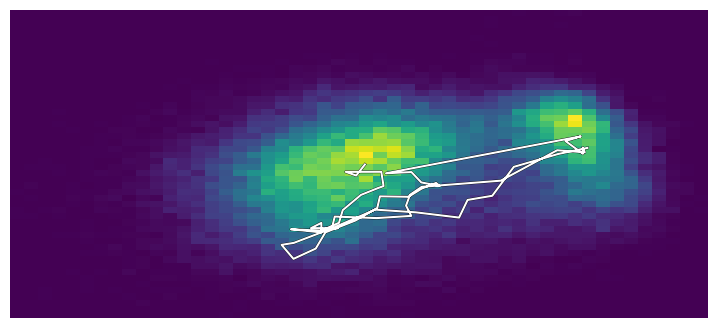

In [17]:
# histograms for input datasets; if these are un-nice, bubblewrap will sometimes get nan's in the alphas and fail.
%matplotlib inline
fig, ax = plt.subplots(ncols=len(input_keys)-1, nrows=1, figsize=(9,4), squeeze=False)


t2 = t1 + 5
for i, key in enumerate(input_keys[:-1]):
    if len(datasets[key][0].shape) > 1 and datasets[key][0].shape[1] > 1:
        x, x_t = datasets[key]
        s = (t1 < x_t) & (x_t < t2)
        # ax[0,i].scatter(x[:,0], x[:,1], s=10)
        ax[0,i].hist2d(x[:,0], x[:,1], [50,50])
        ax[0,i].plot(x[s,0], x[s,1], '-', color='k', linewidth=2)
        ax[0,i].plot(x[s,0], x[s,1], '-', color='w', linewidth=1.5)
        ax[0,i].axis('off')
    # ax[0][i].set_title(key)
fig.savefig(fname="/home/jgould//Downloads/trajectories.svg")

## Run Table

In [18]:
def _simple_bw_run(input_arr, t, time_offsets, bw_params, n_steps):
    bw = adaptive_latents.Bubblewrap(input_arr.shape[1], **bw_params)
    br = adaptive_latents.BWRun(bw, adaptive_latents.NumpyTimedDataSource(input_arr, t, time_offsets), show_tqdm=True)
    br.run(limit=n_steps,save=False)
    return br
simple_bw_run = fin.save_to_cache("simple_bw_run")(_simple_bw_run)

def evaluate(i,o, maxlen=10_000, bw_params=adaptive_latents.default_parameters.default_jpca_dataset_parameters, seed=0, cache=True):
    """
    run bubblewrap on dataset i (the inputs) and run a regression on dataset o (the target outputs)
    
    Note that bubblewrap is run and then the regression is done post-hoc. This is so the bubblewrap run can be cached.
    
    parameters:
        i: the input to bubblewrap; an element of the datasets dictionary (really tuple of `(datapoints, timestamps)`)
        o: same as i, but the a set of variables to try to predict
        maxlen: the point at which to cut off bubblewrap if the dataset is large
        bw_params: the hyperparameters to pass to bubblewrap
        
    returns:
        br: the bubblewrap run (this has lots of useful information)
        pred: the predictions from the regression
        true: the target values from the regression (so basically a slice of the `o` input)
        times: the timestamps for the regression predictions
    """
    i, i_t = fin.clip(*i)
    o, o_t = fin.clip(*o)
    
    o_dt = np.median(np.diff(o_t))
    i_dt = np.median(np.diff(i_t))
    assert int(np.ceil(o_dt/i_dt)) == 1
    n_steps = 1

    if cache:
        br = simple_bw_run(input_arr=i, t=i_t, time_offsets=[0,n_steps], bw_params=bw_params, n_steps=maxlen)
    else:
        br = _simple_bw_run(input_arr=i, t=i_t, time_offsets=[0,n_steps], bw_params=bw_params, n_steps=maxlen)
    
    
    out_ds = adaptive_latents.NumpyTimedDataSource(o, o_t, (n_steps,))
    reg_class = adaptive_latents.regressions.auto_regression_decorator(adaptive_latents.regressions.SemiRegularizedRegressor, n_steps=0, autoregress_only=False)
    reg = reg_class(input_d=br.bw.N, output_d=o.shape[1], regularization_factor=.001)
    
    br.add_regression_post_hoc(reg, out_ds)
    pred = br.h.beh_pred[n_steps]
    true = br.h.beh_pred[n_steps] - br.h.beh_error[n_steps]
    times = br.h.reg_offset_t[n_steps]
    return br, pred, true, times


In [11]:
%%time
# this cell evaluates each element of the table specified above using the `evaluate` function

bw_params = dict(    
    adaptive_latents.default_parameters.default_jpca_dataset_parameters, 
num=100,
eps=1e-3,
step=8e-1,
num_grad_q=2,
)

results = {}
brs = {}
true_values = {}
for okey in output_keys:
    results[okey] = {}
    brs[okey] = {}
    true_values[okey] = {}
    for ikey in input_keys:
        print(f"{okey= } {ikey= }")

        br, pred, true, times = evaluate(datasets[ikey], datasets[okey], maxlen=3_000, bw_params=bw_params)

        results[okey][ikey] = pred
        brs[okey][ikey] = br
        true_values[okey][ikey] = (true, times)

okey= 's(obs,4)' ikey= 's(obs,4)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_429993236160705.pickle
okey= 's(obs,4)' ikey= 'j(s(obs,4))'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_696529222773849.pickle
okey= 'j(s(obs,4))' ikey= 's(obs,4)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_429993236160705.pickle
okey= 'j(s(obs,4))' ikey= 'j(s(obs,4))'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_696529222773849.pickle
okey= 'j(s(obs,4))[:,0]' ikey= 's(obs,4)'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_429993236160705.pickle
okey= 'j(s(obs,4))[:,0]' ikey= 'j(s(obs,4))'
retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_696529222773849.pickle
okey= 's(obs,4)[:,0]' ikey= 's(obs,4)'
retreiving c

dict_keys(['s(obs,4)', 'j(s(obs,4))', 'j(s(obs,4))[:,0]', 's(obs,4)[:,0]', 'beh'])


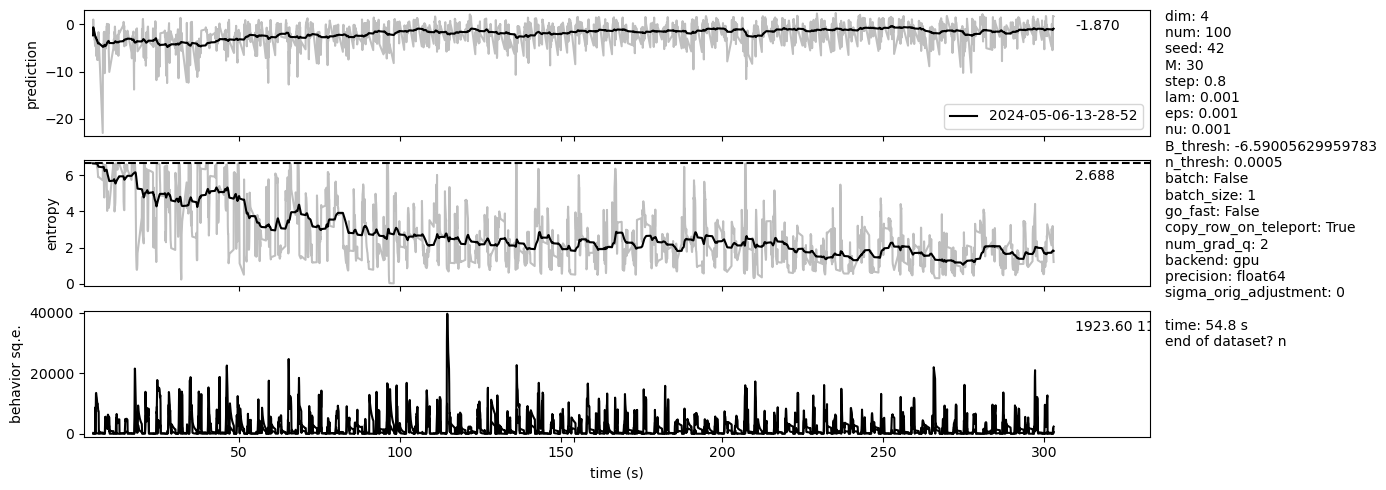

In [12]:
%matplotlib inline
adaptive_latents.plotting_functions.compare_metrics([brs['beh']['j(s(obs,4))'] ], 1)
print(brs.keys())

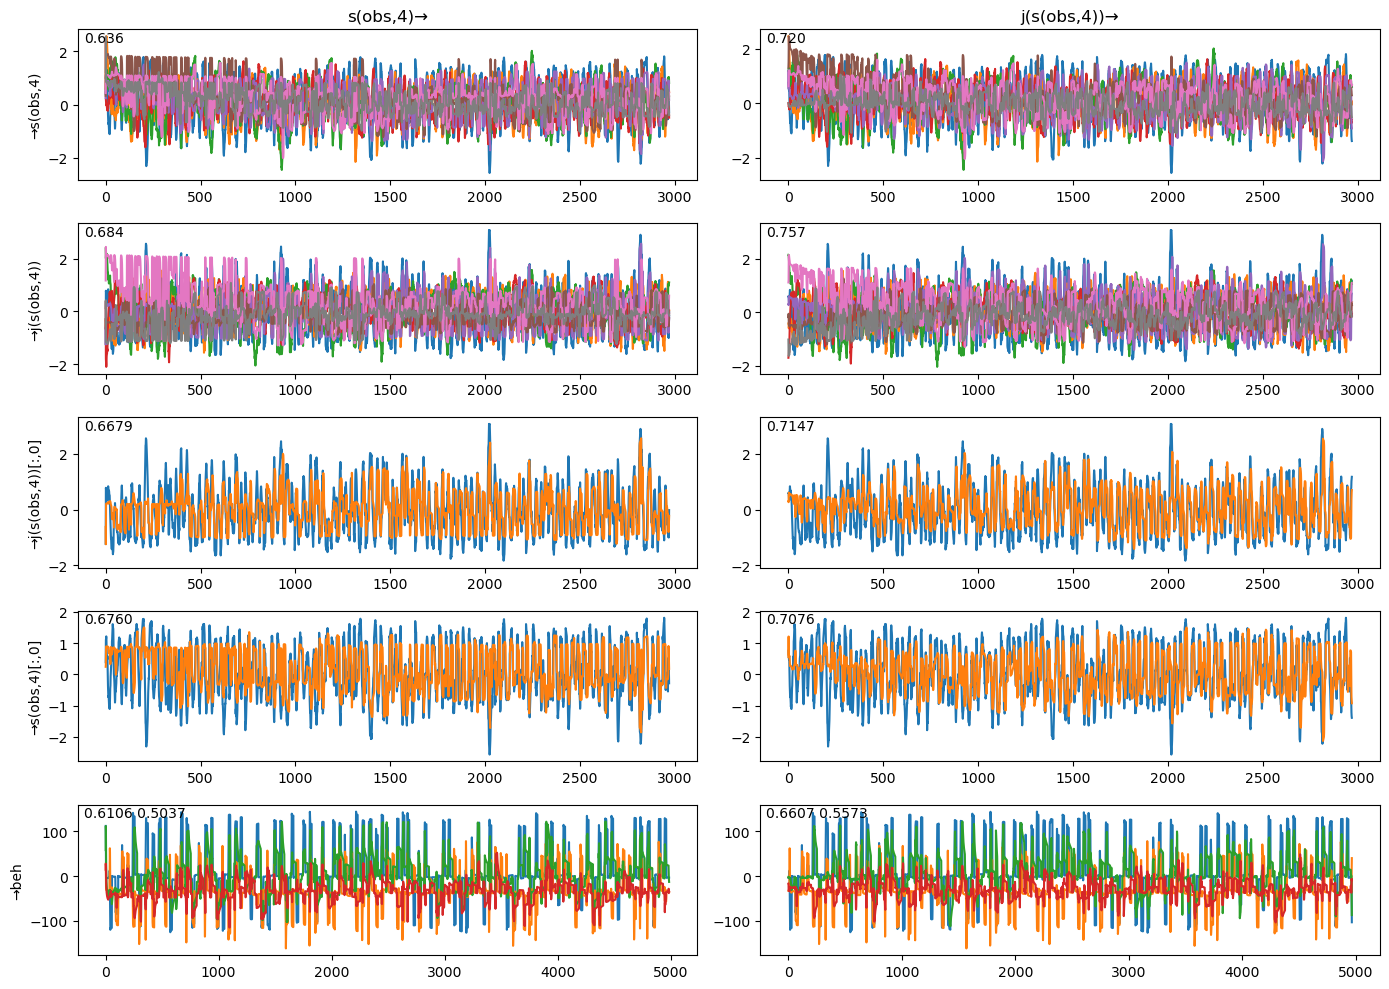

In [19]:
# this cell plots the table of results
%matplotlib inline
def get_corrs_from_br(br):
    offset = br.output_ds.time_offsets[-1]
    
    first_pred_idx = np.nonzero(~np.all(np.isnan(br.h.beh_error[offset]),axis=1))[0][0]
    n_samples_before_end = (br.h.beh_error[offset].shape[0] - first_pred_idx)//2
    
    lh_predicted = br.h.beh_pred[offset][-n_samples_before_end:]
    lh_true = br.h.beh_pred[offset][-n_samples_before_end:] - br.h.beh_error[offset][-n_samples_before_end:]
    
    corrs = [np.corrcoef(lh_true[:,j], lh_predicted[:,j])[0,1] for j in range(lh_true.shape[1])]
    sq_errors = ((lh_predicted - lh_true)**2).mean(axis=0)
    return corrs

fig, ax = plt.subplots(nrows=len(output_keys), ncols=len(input_keys), figsize=(14,2*len(output_keys)), layout='tight', squeeze=False)

s = slice(-1)

for row, okey in enumerate(output_keys):
    ax[row,0].set_ylabel("→" + okey)
    for col, ikey in enumerate(input_keys):
        true, times, predicted = fin.clip(*true_values[okey][ikey], results[okey][ikey])
        
        br = brs[okey][ikey]

        corrs = get_corrs_from_br(br)

        ax[row,col].plot(true[s])
        ax[row,col].plot(predicted[s], '-')
        
        if true.shape[1] < 4:
            corrs = " ".join([f"{c:.4f}" for c in corrs])
        else:
            corrs = f"{np.mean(corrs):.3f}"
        ax[row,col].text(.01,.99, corrs, ha='left', va='top', transform=ax[row, col].transAxes)
        if row == 0:
            ax[0,col].set_title(ikey +  "→")

In [14]:
output_keys

['s(obs,4)', 'j(s(obs,4))', 'j(s(obs,4))[:,0]', 'beh']

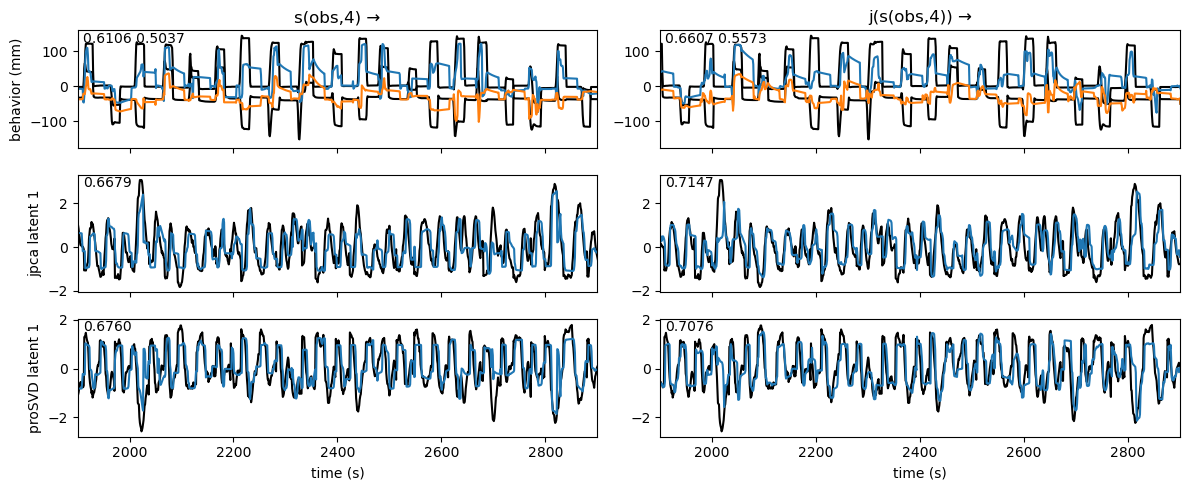

In [22]:
%matplotlib inline
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,5), layout='tight', squeeze=False, sharex=True)

for row, okey in enumerate(['beh', 'j(s(obs,4))[:,0]', 's(obs,4)[:,0]']):
    # ax[row,0].set_ylabel("→" + okey)
    for col, ikey in enumerate(['s(obs,4)', 'j(s(obs,4))',]):
        true, times, predicted = fin.clip(*true_values[okey][ikey], results[okey][ikey])
        
        br = brs[okey][ikey]

        corrs = get_corrs_from_br(br)

        
        ax[row,col].plot(true[s], 'k')
        ax[row,col].plot(predicted[s], '-')

        ax[row,col].set_xlim([1900, 2900])

        if true.shape[1] < 4:
            corrs = " ".join([f"{c:.4f}" for c in corrs])
        else:
            corrs = f"{np.mean(corrs):.3f}"
        ax[row,col].text(.01,.99, corrs, ha='left', va='top', transform=ax[row, col].transAxes)
        
        if row == 0:
            ax[0,col].set_title(ikey +  " →")
for a in ax[-1,:]:
    a.set_xlabel("time (s)")
ax[0,0].set_ylabel("behavior (mm)")
ax[1,0].set_ylabel("jpca latent 1")
ax[2,0].set_ylabel("proSVD latent 1")

fig.savefig(fname="/home/jgould//Downloads/predictions.svg")

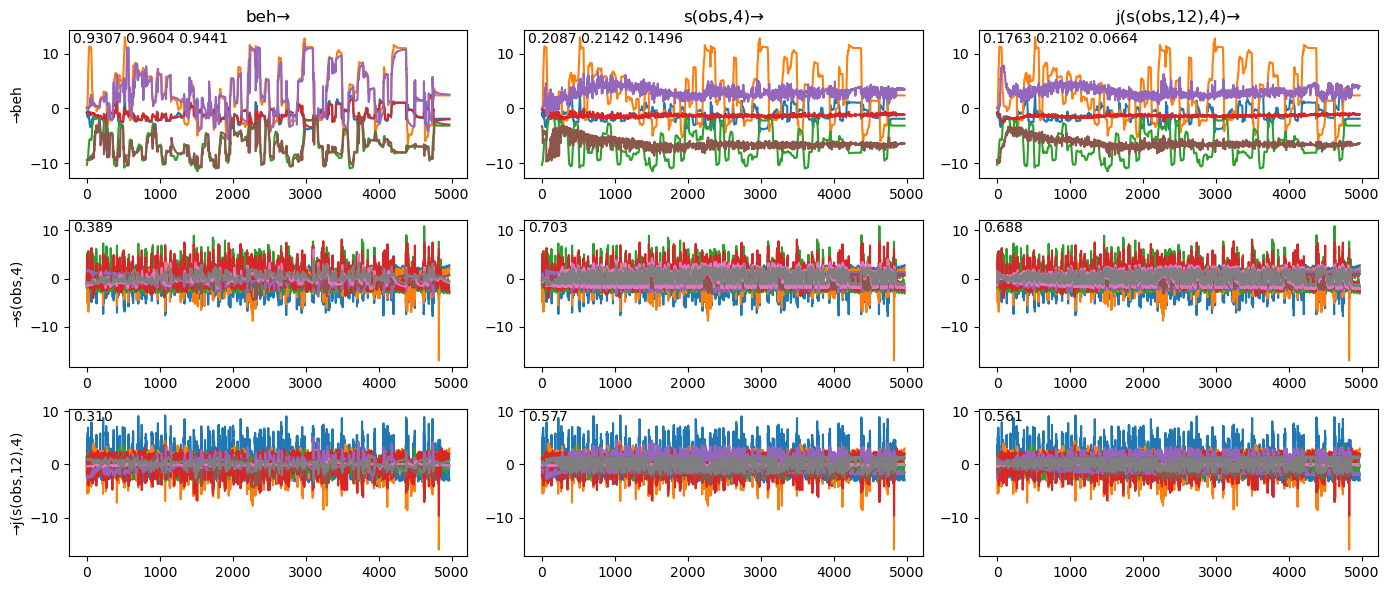

In [23]:
# this cell plots the table of results

def get_corrs_from_br(br):
    offset = br.output_ds.time_offsets[-1]
    
    first_pred_idx = np.nonzero(~np.all(np.isnan(br.h.beh_error[offset]),axis=1))[0][0]
    n_samples_before_end = (br.h.beh_error[offset].shape[0] - first_pred_idx)//2
    
    lh_predicted = br.h.beh_pred[offset][-n_samples_before_end:]
    lh_true = br.h.beh_pred[offset][-n_samples_before_end:] - br.h.beh_error[offset][-n_samples_before_end:]
    
    corrs = [np.corrcoef(lh_true[:,j], lh_predicted[:,j])[0,1] for j in range(lh_true.shape[1])]
    sq_errors = ((lh_predicted - lh_true)**2).mean(axis=0)
    return corrs

fig, ax = plt.subplots(nrows=len(output_keys), ncols=len(input_keys), figsize=(14,2*len(output_keys)), layout='tight', squeeze=False)

s = slice(-1)

for row, okey in enumerate(output_keys):
    ax[row,0].set_ylabel("→" + okey)
    for col, ikey in enumerate(input_keys):
        true, times, predicted = fin.clip(*true_values[okey][ikey], results[okey][ikey])
        
        br = brs[okey][ikey]

        corrs = get_corrs_from_br(br)

        ax[row,col].plot(true[s])
        ax[row,col].plot(predicted[s])
        
        if true.shape[1] < 4:
            corrs = " ".join([f"{c:.4f}" for c in corrs])
        else:
            corrs = f"{np.mean(corrs):.3f}"
        ax[row,col].text(.01,.99, corrs, ha='left', va='top', transform=ax[row, col].transAxes)
        if row == 0:
            ax[0,col].set_title(ikey +  "→")

## Table summary for Sheets

In [51]:
row_to_break_out = "s(obs,4)"

In [39]:
df = pd.DataFrame(brs).T

In [40]:
def f(br):
    lh_pred, lh_true, _ = br.get_behavior_last_half(br.obs_ds.time_offsets[-1])
    l = [np.corrcoef(np.squeeze([lh_pred[:,j], lh_true[:,j]]))[0,1] for j in range(lh_true.shape[1])]
    if len(l) < 4:
        pass
    else:
        l = [np.mean(l)]
    return ", ".join([str(round(x,2)) for x in l])

In [41]:
table = df.applymap(f)
table.loc["pred"] = df.applymap(lambda x: x.log_pred_p_summary(offset=1)).mean(axis=0)
table.loc["ent"] =  df.applymap(lambda x: x.entropy_summary(offset=1)).mean(axis=0)
# the mean in the above two lines is just a formality; technically the values might be different across rows because of clipping

/tmp/ipykernel_146730/1172322258.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = df.applymap(f)
/tmp/ipykernel_146730/1172322258.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table.loc["pred"] = df.applymap(lambda x: x.log_pred_p_summary(offset=1)).mean(axis=0)
/tmp/ipykernel_146730/1172322258.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table.loc["ent"] =  df.applymap(lambda x: x.entropy_summary(offset=1)).mean(axis=0)


In [42]:
temp = {key: get_corrs_from_br(value) for key, value in brs[row_to_break_out].items()}
temp = pd.DataFrame(temp, index=[row_to_break_out + f"_{n}" for n in range(datasets[row_to_break_out][0].shape[1])])

In [43]:
pd.concat([table, temp]) # you can copy-paste this right into Sheets

,"s(obs,4)","s([obs,beh],4)",beh
"s(obs,4)",0.86,0.9,0.59
beh,0.86,0.9,0.57
pred,1.821789,-0.650424,-0.098251
ent,1.238005,1.396288,1.773525
"s(obs,4)_0",0.90518,0.922669,0.614561
"s(obs,4)_1",0.829449,0.868321,0.715155
"s(obs,4)_2",0.830188,0.881207,0.376473
"s(obs,4)_3",0.885419,0.926634,0.664297


Text(0, 0.5, 'individual r^2 per component in "s(obs,4)"')

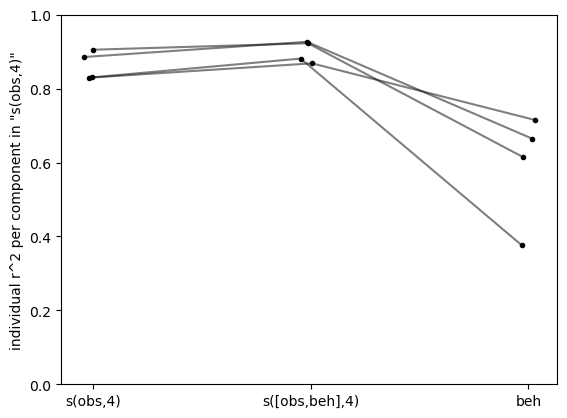

In [44]:
for i in range(temp.shape[0]):
    jitter = (rng.random(size=temp.shape[1])-.5) * .1
    plt.plot(np.arange(temp.shape[1]) + jitter, temp.iloc[i,:], 'k.')
    plt.plot(np.arange(temp.shape[1]) + jitter, temp.iloc[i,:], 'k-', alpha=.5)

plt.ylim([0,1])
plt.xticks(ticks = np.arange(temp.shape[1]), labels=temp.columns)
plt.ylabel(f'individual r^2 per component in "{row_to_break_out}"')

## Optimizing parameters

In [45]:
datasets.keys() # this is so I have the text of the keys ready to copy-paste

dict_keys(['s(obs,4)', 's([obs,beh],4)', 'beh'])

In [46]:
brs2 = [] # this is a history of bubblewrap runs; reset it when the plots are getting too full

In [49]:
%%time
brs2.append(evaluate(i=datasets['s(obs,4)'], o=datasets['s(obs,4)'], maxlen=5_000, 
                     bw_params=
                     dict(
                        adaptive_latents.default_parameters.default_jpca_dataset_parameters,
                        num=100,
                        eps=1e-5,
                        step=.5,
                        num_grad_q=4,
                     )
                    )[0])

retreiving cache from: /home/jgould/Documents/Bubblewrap/generated/datasets/cache/simple_bw_run_433451057043727.pickle


Exception: No config file found.

In [ ]:
assert len(brs2) < 8 # this is actually fine, but just be aware that the later part of the cell slices 

colors = ['k']*(len(brs2))
colors[-1] = 'r'
bpf.compare_metrics(brs2[-7:], colors=colors[-7:], offset=1, show_legend=False)

## Choosing the better predictor

In [ ]:
datasets.keys()

In [ ]:
output_key = output_keys[0]
output_key = "s(obs,6)[:,5]"

In [ ]:
n_steps_ahead = 1

br = brs[output_key][input_keys[0]]
truth = br.behavior_pred_history[n_steps_ahead] - br.behavior_error_history[n_steps_ahead]

clipped = fin.clip(
    truth,
    *[brs[output_key][input_key].behavior_pred_history[n_steps_ahead] for input_key in brs[output_key]]
)
truth = clipped[0]
preds = np.squeeze(clipped[1:]).T


In [ ]:
preds.shape

In [ ]:
combined_estimate = []
errors = preds - truth

n_to_consider = 4

for i in range(1,len(errors)):
    a = errors[i-n_to_consider:i]
    bests = (np.abs(a) - np.abs(a).min(axis=1)[:,None]) == 0
    best_last_time = np.argmax(bests.sum(axis=0))
    combined_estimate.append(preds[i, best_last_time])
combined_estimate = np.squeeze(combined_estimate)

In [ ]:
preds, combined_estimate, truth = fin.clip(preds, combined_estimate, truth)
s = slice(1500, 1600)
plt.plot(truth[s], 'k');
plt.plot(preds[s], 'r', alpha=0.25)
plt.plot(combined_estimate[s], 'r');


In [ ]:
heights = list((errors**2).mean(axis=0)) + [(combined_estimate**2).mean()]
x = list(np.arange(errors.shape[1] + 1))
plt.bar(x, heights)
plt.ylabel("MSE")
plt.xlabel("predictor")
plt.xticks(x, labels=[xx for xx in x[:-1]] + ["combined"]);

In [ ]:
np.corrcoef(truth.T, combined_estimate[:,None].T)[0,1]